In [2]:
import zipfile

with zipfile.ZipFile('liardataset.zip', 'r') as zip_ref:
    zip_ref.extractall('liar_dataset') 


In [3]:
import os
os.listdir("liar_dataset")


['.ipynb_checkpoints', 'README', 'test.tsv', 'train.tsv', 'valid.tsv']

In [4]:
import pandas as pd
train_df=pd.read_csv("liar_dataset/train.tsv",sep="\t",header=None)
valid_df=pd.read_csv("liar_dataset/valid.tsv",sep="\t",header=None)
test_df=pd.read_csv("liar_dataset/test.tsv",sep="\t",header=None)


In [5]:
df=pd.concat([train_df,valid_df,test_df],ignore_index=True)

In [6]:

df.columns = [
    'id', 'label', 'statement', 'subject', 'speaker',
    'speaker_job_title', 'state_info', 'party_affiliation',
    'barely_true_counts', 'false_counts', 'half_true_counts',
    'mostly_true_counts', 'pants_on_fire_counts', 'context'
]


In [7]:
print(df.shape)

(12791, 14)


In [8]:
print(df.columns)

Index(['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title',
       'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context'],
      dtype='object')


In [9]:
print(df.head())
print(df.tail())


           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                              subject         speaker     speaker_job_title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

  state_info party_affiliation  barely

In [10]:
fake_labels = ['pants-fire', 'false', 'barely-true', 'half-true']
real_labels = ['mostly-true', 'true']

df['binary_label'] = df['label'].apply(lambda x: 1 if x in fake_labels else 0)


In [11]:
df.isnull().sum()

id                         0
label                      0
statement                  0
subject                    2
speaker                    2
speaker_job_title       3568
state_info              2751
party_affiliation          2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  131
binary_label               0
dtype: int64

In [12]:
df.fillna({
    'speaker_job_title': 'Unknown',
    'state_info': 'Unknown',
    'context': 'Unknown',
    'subject': 'Unknown',
    'speaker': 'Unknown',
    'party_affiliation': 'Unknown'
}, inplace=True)


In [13]:
count_columns = [
    'barely_true_counts',
    'false_counts',
    'half_true_counts',
    'mostly_true_counts',
    'pants_on_fire_counts'  
]
for col in count_columns:
    df[col]=df[col].fillna(0.0)

In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df.isnull().sum()

id                      0
label                   0
statement               0
subject                 0
speaker                 0
speaker_job_title       0
state_info              0
party_affiliation       0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
binary_label            0
dtype: int64

In [16]:
print(df['binary_label'].value_counts())


binary_label
1    8284
0    4507
Name: count, dtype: int64


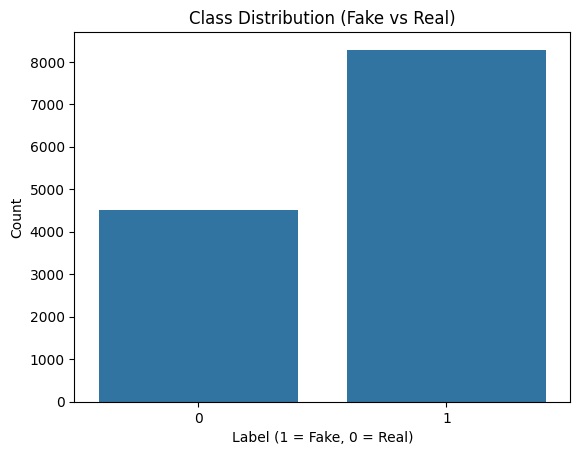

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='binary_label')
plt.title("Class Distribution (Fake vs Real)")
plt.xlabel("Label (1 = Fake, 0 = Real)")
plt.ylabel("Count")
plt.show()

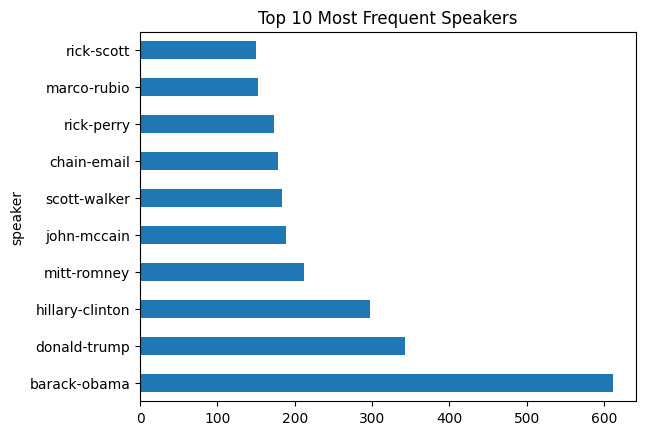

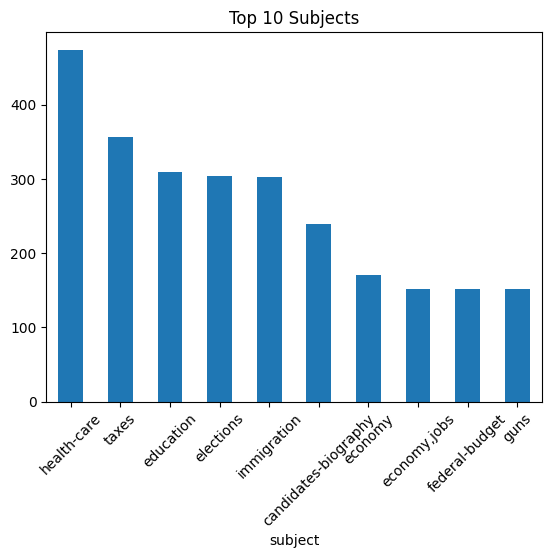

In [20]:
df['speaker'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Most Frequent Speakers')
plt.show()

df['subject'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Subjects')
plt.xticks(rotation=45)
plt.show()

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(df['statement'])
y = df['binary_label']


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.50      0.20      0.29       902
           1       0.67      0.89      0.77      1657

    accuracy                           0.65      2559
   macro avg       0.59      0.55      0.53      2559
weighted avg       0.61      0.65      0.60      2559

Accuracy: 0.6483001172332943


In [24]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))


Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.56      0.15      0.24       902
           1       0.67      0.94      0.78      1657

    accuracy                           0.66      2559
   macro avg       0.62      0.54      0.51      2559
weighted avg       0.63      0.66      0.59      2559

Accuracy: 0.6596326690113326


In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.53      0.21      0.30       902
           1       0.68      0.89      0.77      1657

    accuracy                           0.65      2559
   macro avg       0.60      0.55      0.54      2559
weighted avg       0.62      0.65      0.61      2559

Accuracy: 0.6549433372411098


In [27]:
print("\n Accuracy Comparison:")
print("Logistic Regression:", accuracy_score(y_test, y_pred_lr))
print("Naive Bayes:", accuracy_score(y_test, y_pred_nb))
print("Random Forest:", accuracy_score(y_test, y_pred_rf))



 Accuracy Comparison:
Logistic Regression: 0.6483001172332943
Naive Bayes: 0.6596326690113326
Random Forest: 0.6549433372411098


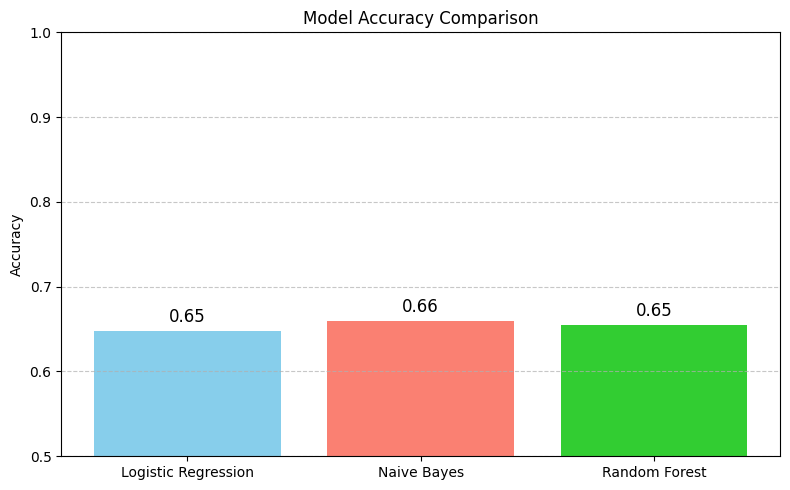

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


acc_logistic = accuracy_score(y_test, y_pred_lr)
acc_nb = accuracy_score(y_test, y_pred_nb)
acc_rf = accuracy_score(y_test, y_pred_rf)


models = ['Logistic Regression', 'Naive Bayes', 'Random Forest']
accuracies = [acc_logistic, acc_nb, acc_rf]


plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['skyblue', 'salmon', 'limegreen'])
plt.ylim(0.5, 1.0)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
